In [ ]:
import timm
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os
import sys
import shutil
import random

In [ ]:
# Set random seed for reproducibility
random.seed(42)

# Source and destination directories
src_dir = 'filtered_images'  # Folder containing original class folders with images
dst_train = os.path.join('data', 'train')  # Destination for training images
dst_val = os.path.join('data', 'val')      # Destination for validation images
dst_test = os.path.join('data', 'test')    # Destination for test images

# Class names
classes = ['France', 'Greece', 'Italy', 'Japan', 'Mexico']

# Clear out existing images in train and val class folders
for split_dir in [dst_train, dst_val, dst_test]:
    for cls in classes:
        class_dir = os.path.join(split_dir, cls)
        if os.path.exists(class_dir):
            # Remove all files in the class directory
            for f in os.listdir(class_dir):
                file_path = os.path.join(class_dir, f)
                if os.path.isfile(file_path):
                    os.remove(file_path)

# For each class, split images and copy to train/val folders
for cls in classes:
    src_cls_dir = os.path.join(src_dir, cls)  # Source directory for this class
    # List all files in the class directory
    images = [f for f in os.listdir(src_cls_dir) if os.path.isfile(os.path.join(src_cls_dir, f))]
    random.shuffle(images)  # Shuffle for random split

    n_total = len(images)
    n_train = int(0.7 * n_total)  # 70% for training
    n_val = int(0.15 * n_total)    # 15% for validation

    train_imgs = images[:n_train]  # First 70% for train
    val_imgs = images[n_train:n_train + n_val]  # Next 15% for val
    test_imgs = images[n_train + n_val:]  # Remaining 15% for test

    # Copy train images to train/class folder
    for img in train_imgs:
        src_path = os.path.join(src_cls_dir, img)
        dst_path = os.path.join(dst_train, cls, img)
        shutil.copy2(src_path, dst_path)

    # Copy val images to val/class folder
    for img in val_imgs:
        src_path = os.path.join(src_cls_dir, img)
        dst_path = os.path.join(dst_val, cls, img)
        shutil.copy2(src_path, dst_path)

    # Copy test images to test/class folder
    for img in test_imgs:
        src_path = os.path.join(src_cls_dir, img)
        dst_path = os.path.join(dst_test, cls, img)
        shutil.copy2(src_path, dst_path)

print("Images have been split and copied to 'data/train', 'data/val', and 'data/test with even class distribution.")

In [ ]:
print(torch.version.cuda)
print(sys.executable)

None
c:\Users\anwar\Documents\uni\APS360\Project\venv\Scripts\python.exe


In [ ]:
print(sys.executable)
print("CUDA:", torch.cuda.is_available(), "CUDA ver:", torch.version.cuda, "Torch:", torch.__version__)


c:\Users\anwar\Documents\uni\APS360\Project\venv\Scripts\python.exe
CUDA: False CUDA ver: None Torch: 2.8.0+cpu


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_model_name(name, batch_size, learning_rate, epoch):
        """ Generate a name for the model consisting of all the hyperparameter values

        Args:
            config: Configuration object containing the hyperparameters
        Returns:
            path: A string with the hyperparameter name and value concatenated
        """
        path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
        return path

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.set_float32_matmul_precision("high")  
use_amp = (device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Using device: cpu


C:\Users\anwar\AppData\Local\Temp\ipykernel_26408\579997826.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [22]:
torch.cuda.is_available()

False

In [23]:
IMSIZE = 260
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMSIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.02),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_tfms = transforms.Compose([
    transforms.Resize(int(IMSIZE*1.1)),
    transforms.CenterCrop(IMSIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [24]:
num_countries = 5

model = timm.create_model(
    'efficientnet_b5',
    pretrained=True,
    num_classes=num_countries,
    drop_rate=0.3,
    drop_path_rate=0.1
)

if device.type == "cuda":
    model = model.to(device, memory_format=torch.channels_last)
else:
    model = model.to(device)

In [25]:
mixup_fn = Mixup(mixup_alpha=0.2, cutmix_alpha=1.0, prob=1.0)
criterion = SoftTargetCrossEntropy()


def train_val(model, lr, batch_size, num_epochs):
    train_dataset = ImageFolder(root='data/train', transform=train_tfms)
    val_dataset = ImageFolder(root='data/val', transform=val_tfms)

    pin = (device.type == "cuda")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=pin, persistent_workers=True, prefetch_factor=4)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=pin, persistent_workers=True, prefetch_factor=4)

    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_loss_array = np.zeros(num_epochs)
    val_loss_array = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        train_loss = 0
        train_correct = 0
        total = 0

        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_countries).float()
            loss = criterion(outputs, one_hot_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_loss_array[epoch] = avg_train_loss
        train_acc = 100. * train_correct / total
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        # Validation
        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_countries).float()
                loss = criterion(outputs, one_hot_labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_array[epoch] = avg_val_loss
        val_acc = 100. * val_correct / val_total
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Save checkpoint
        model_path = get_model_name("efficientnet_b5", batch_size, lr, epoch)
        torch.save(model.state_dict(), model_path)
        
        scheduler.step()

    # Save loss curves
    np.savetxt(f"{model_path}_train_loss.csv", train_loss_array)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss_array)
    plot_training_curve(model_path)

    return val_acc


In [26]:
import random
# from sklearn.model_selection import ParameterGrid
parameter_options = {
    'lr': [0.0003],
    'batch_size': [16],
    'num_epochs': [20]
}

best_parameters = None
best_val_accuracy = 0.0

# for params in ParameterGrid(parameter_options):
for i in range(5):
    params = {k: random.choice(v) for k, v in parameter_options.items()}
    print(f"Training with parameters: {params}")
    val_acc = train_val(model, params['lr'], params['batch_size'], params['num_epochs'])
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_parameters = params

print(f"Best parameters: {best_parameters} with validation accuracy: {best_val_accuracy:.2f}%")

Training with parameters: {'lr': 0.0003, 'batch_size': 16, 'num_epochs': 20}


Epoch 1/20:   0%|          | 0/138 [00:09<?, ?it/s]


KeyboardInterrupt: 

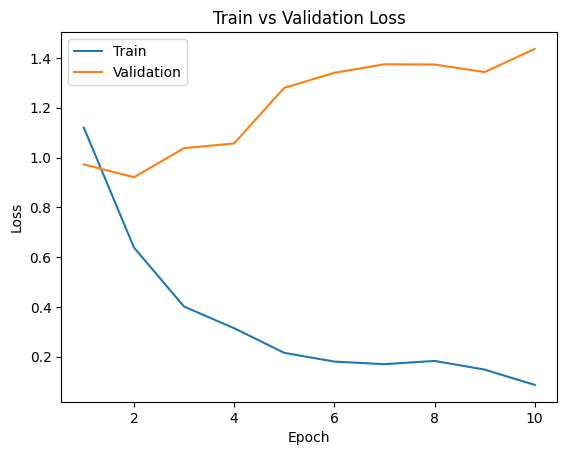

In [ ]:
# Write the train/test loss/err into CSV file for plotting later
epoch = np.arange(1, num_epochs+1)
np.savetxt("{}_train_loss.csv".format(model_path), train_loss_array)
np.savetxt("{}_val_loss.csv".format(model_path), val_loss_array)
netPath = get_model_name("efficientnet_b5", best_parameters['batch_size'], best_parameters['lr'], best_parameters['num_epochs']-1)
plot_training_curve(netPath)

In [ ]:
# Test
test_dataset = ImageFolder(root='data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
model_path = get_model_name("efficientnet_b2", batch_size, lr, num_epochs-1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

average_test_loss = test_loss / len(test_loader)
test_accuracy = 100.0 * test_correct / test_total
print(f"Test Loss: {average_test_loss:.4f}\nTest Accuracy: {test_accuracy:.2f}%")